In [0]:
#Keras library for CIFAR dataset
from keras.datasets import cifar10

In [0]:
#Downloading the CIFAR dataset
(x_train,y_train),(x_test,y_test)=cifar10.load_data()

In [0]:
#importing other required libraries
import numpy as np
import pandas as pd
from sklearn.utils.multiclass import unique_labels
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras import Sequential
from keras.applications import VGG19,ResNet50 ##VGG19 and RsNet50 for Transfer Learning
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD,Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from keras.utils import to_categorical

In [0]:
#defining training and test sets
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=.3)

In [26]:
#Dimension of the dataset
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((35000, 32, 32, 3), (35000, 1))
((15000, 32, 32, 3), (15000, 1))
((10000, 32, 32, 3), (10000, 1))


In [0]:
#Onehot Encoding the labels.
#Since we have 10 classes we should expect the shape[1] of y_train,y_val and y_test to change from 1 to 10
y_train=to_categorical(y_train)
y_val=to_categorical(y_val)
y_test=to_categorical(y_test)

In [28]:
#Verifying the dimension after onehot encoding
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((35000, 32, 32, 3), (35000, 10))
((15000, 32, 32, 3), (15000, 10))
((10000, 32, 32, 3), (10000, 10))


In [0]:
#Image Data Augmentation
train_generator = ImageDataGenerator(
                                    rotation_range=2, 
                                    horizontal_flip=True,
                                    zoom_range=.1 )

val_generator = ImageDataGenerator(
                                    rotation_range=2, 
                                    horizontal_flip=True,
                                    zoom_range=.1)

test_generator = ImageDataGenerator(
                                    rotation_range=2, 
                                    horizontal_flip= True,
                                    zoom_range=.1) 

In [0]:
#Fitting the augmentation defined above to the data
train_generator.fit(x_train)
val_generator.fit(x_val)
test_generator.fit(x_test)

In [0]:
#Learning Rate Annealer
lrr= ReduceLROnPlateau(
                       monitor='val_acc', #Metric to be measured
                       factor=.01, #Factor by which learning rate will be reduced
                       patience=3,  #No. of epochs after which if there is no improvement in the val_acc, the learning rate is reduced
                       min_lr=1e-5) #The minimum learning rate 

In [0]:
#Defining the VGG Convolutional Neural Net
base_model = VGG19(include_top=False,weights='imagenet',input_shape=(32,32,3),classes=y_train.shape[1])

In [0]:
#Adding the final layers to the above base models where the actual classification is done in the dense layers

model= Sequential()
model.add(base_model) #Adds the base model (in this case vgg19 to model)
model.add(Flatten()) #Since the output before the flatten layer is a matrix we have to use this function to get a vector of the form nX1 to feed it into the fully connected layers

In [34]:
#Model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 1, 1, 512)         20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
Total params: 20,024,384
Trainable params: 20,024,384
Non-trainable params: 0
_________________________________________________________________


In [0]:
#Adding the Dense layers along with activation and batch normalization
model.add(Dense(1024,activation=('relu'),input_dim=512))
model.add(Dense(512,activation=('relu'))) 
model.add(Dense(256,activation=('relu'))) 
#model.add(Dropout(.3))#Adding a dropout layer that will randomly drop 30% of the weights
model.add(Dense(128,activation=('relu')))
#model.add(Dropout(.2))
model.add(Dense(10,activation=('softmax'))) #This is the classification layer

In [36]:
#Checking the final model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 1, 1, 512)         20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_7 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_8 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_9 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_10 (Dense)             (None, 10)               

In [0]:
#Defining the parameters
batch_size= 100
epochs=50
learn_rate=.001

sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)
adam=Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [0]:
#Compiling the model
#During model compiling the 3 main things we specify are loss function,optimizer and the metrics that need to be evaluated during the test and train processes.
#Lets start by using the SGD optimizer
#We will specify the loss as categoricl crossentropy since the labels are 1 hot encoded. IF we had integer labels,we'd have to use sparse categorical crossentropy as loss function.
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

In [39]:
#Training the model
model.fit_generator(train_generator.flow(x_train,y_train,batch_size=batch_size),
                      epochs=epochs,
                      steps_per_epoch=x_train.shape[0]//batch_size,
                      validation_data=val_generator.flow(x_val,y_val,batch_size=batch_size),validation_steps=250,
                      callbacks=[lrr],verbose=1)

Epoch 1/50
350/350 [==============================] - 62s 177ms/step - loss: 2.0878 - accuracy: 0.2019 - val_loss: 1.8054 - val_accuracy: 0.3510
Epoch 2/50
  1/350 [..............................] - ETA: 45s - loss: 1.7636 - accuracy: 0.3400

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


350/350 [==============================] - 61s 175ms/step - loss: 1.3632 - accuracy: 0.4972 - val_loss: 1.0819 - val_accuracy: 0.6115
Epoch 3/50
350/350 [==============================] - 61s 175ms/step - loss: 0.9861 - accuracy: 0.6525 - val_loss: 1.0423 - val_accuracy: 0.7058
Epoch 4/50
350/350 [==============================] - 61s 174ms/step - loss: 0.7858 - accuracy: 0.7273 - val_loss: 0.6539 - val_accuracy: 0.7510
Epoch 5/50
350/350 [==============================] - 61s 175ms/step - loss: 0.6853 - accuracy: 0.7663 - val_loss: 0.7074 - val_accuracy: 0.7745
Epoch 6/50
350/350 [==============================] - 61s 176ms/step - loss: 0.5988 - accuracy: 0.7957 - val_loss: 0.6143 - val_accuracy: 0.7777
Epoch 7/50
350/350 [==============================] - 61s 175ms/step - loss: 0.5359 - accuracy: 0.8165 - val_loss: 0.4791 - val_accuracy: 0.7968
Epoch 8/50
350/350 [==============================] - 61s 175ms/step - loss: 0.4861 - accuracy: 0.8321 - val_loss: 0.5940 - val_accuracy: 0.8

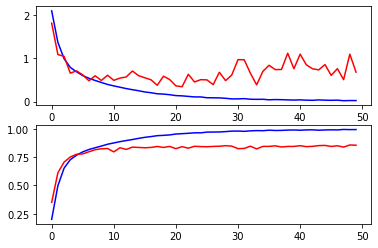

In [40]:
#Plotting the training and valiation loss

f,ax=plt.subplots(2,1) #Creates 2 subplots under 1 column

#Assigning the first subplot to graph training loss and validation loss
ax[0].plot(model.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model.history.history['val_loss'],color='r',label='Validation Loss')

#Plotting the training accuracy and validation accuracy
ax[1].plot(model.history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(model.history.history['val_accuracy'],color='r',label='Validation Accuracy')

In [0]:
#Defining function for confusion matrix plot
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

In [0]:
#Making prediction
y_pred=model.predict_classes(x_test)
y_true=np.argmax(y_test,axis=1)

In [0]:
#Plotting the confusion matrix
confusion_mtx=confusion_matrix(y_true,y_pred)

In [0]:
class_names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Confusion matrix, without normalization


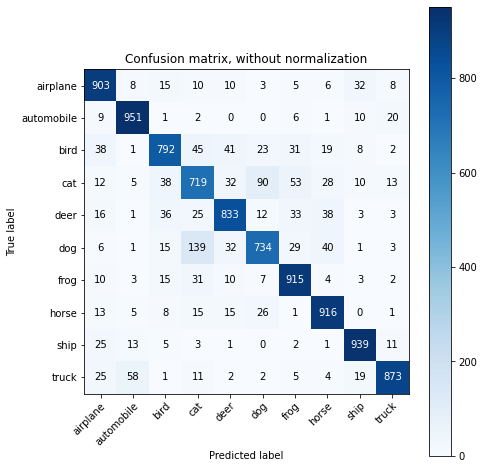

In [45]:
# Plotting non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

Normalized confusion matrix


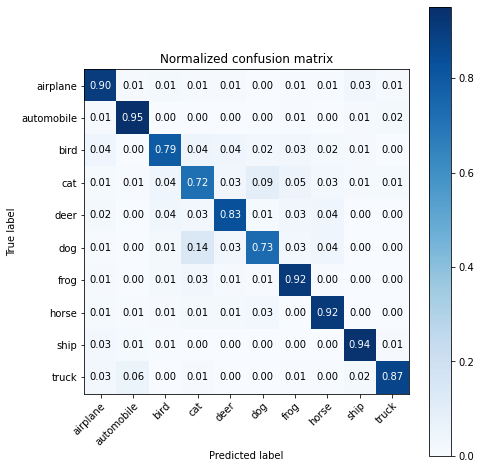

In [46]:
# Plotting normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')